# 工作方式

TensorBoard通过操作将数据记录到文件中，读取文件 => 作图

1、操作：summary - 定义计算图时，在适当的位置增加一些summary操作

2、merge：tf.summary.merge_all将所有summary聚合成一个操作（产生所有的summary数据）

3、run：

> tf.summary.FileWriter指定目录，记录所有产生的文件

> add_summary将某一步的summary数据记录到文件中

训练完成后，通过启动Tensorboard

tensorboard --logdir=指定目录

# 常用结点定义

## 基础功能

1、tf.name_scope() 图中结点

2、tf.summary.scalar()记录评估数据（准确率、损失）

3、tf.summary.merge_all()结合所有的操作

4、tf.summary.FileWriter()所有操作写到日志文件

tf.summary.FileWriter('./tensorboard/log/', graph=tf.get_default_graph())


## 附加功能

### 保存模型，显示运行时间和内存使用情况

In [1]:
# saver = tf.train.Saver()

# run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
# run_metadata = tf.RunMetadata()

# summary_writer.add_run_metadata(run_metadata, 'step%d' % (i * total_batch + batch))
# saver.save(sess, './tensorboard/log/model.ckpt', i * total_batch + batch)

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 结构+评估+优化

![Flowchart](images/02_network_flowchart.png)

1、第一层卷积层：

滤波器：16个5*5滤波器

输出：28*28的图像降采样到16个14*14的图像

2、第二层卷积层：

滤波器：16 X 36个5*5的滤波器

输出：16个14 * 14的图像降采样到36个7*7的图像

3、全连接层：

7*7*36的向量 => 128个特征

4、全连接层：

128个特征 => 10个特征

5、softmax层：

多分类

评估：

交叉熵：测量预测和真实值的差别

优化：

GD将误差后向传播，更新滤波器的权重

filter滤波器属性：

大小

步长stride

填充：padding

输出：ReLU

maxpooling：

最大池化进行降采样，2*2只保留像素中的最大值

效果：输入图的分辨率减小一般，从28*28 => 14*14

# 导入附加

## 导入库+数据

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [4]:
print (tf.__version__)

1.12.0


In [5]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


## 设置辅助变量和函数

In [7]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

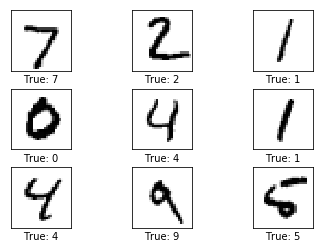

In [9]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Tensorflow图

## 神经网络参数配置

In [10]:
# 第一层卷积层
filter_size1 = 5
num_filters1 = 16

# 第二层卷积层
filter_size2 = 5
num_filters2 = 36

# 全连接层
fc_size = 128  # 全连接层结点数量

## 辅助函数

### 新变量的辅助函数

根据给定大小创建Tensorflow变量，将他们随机初始化

In [11]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.5))

In [12]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### 卷积层的辅助函数

输入：

1、图像数量

2、每张图像的n*n

3、每张图像channel

输出：

1、图像数量=输入数量

2、图像n*n

3、卷积滤波生成的通道数

https://www.tensorflow.org/api_guides/python/nn#Convolution

conv2d的padding='Same':

n(output) = ceil(n(input) / stride)



**'Valid':**

n(output) = ceil(n(input) - filter_size + 1) / stride)

maxpooling的padding='Same':

最终高宽 = hight/weight除以2向上取整

In [13]:
def new_conv_layer(input, 
                  num_input_channels,
                  filter_size,
                  num_filters,
                  use_pooling=True):
    
    with tf.name_scope('layer'):
        # 滤波器的形状设置
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        with tf.name_scope('weights'):
            # 根据滤波器的形状设置权重
            weights = tf.Variable(tf.truncated_normal(shape, stddev=0.5), name='W')
        with tf.name_scope('biases'):
            # 根据滤波器的数量设置偏差
            biases =  tf.Variable(tf.constant(0.05, shape=[num_filters]), name='bias')

        # 创建新的tensorflow卷积层
        # strides参数：图像数量、X轴stride、Y轴stride、输入的通道数
        # padding参数：SAME=padded with zeroes
        layer = tf.nn.conv2d(input=input,
                            filter=weights,
                            strides=[1, 1, 1, 1], 
                            padding='SAME')
        
        layer += biases

        if use_pooling:

            layer = tf.nn.max_pool(value=layer,
                                  ksize=[1, 2, 2, 1],
                                  strides=[1, 2, 2 ,1],
                                  padding='SAME')
        # ReLU=max(x, 0)
        layer = tf.nn.relu(layer)
    
    # 返回结果层和权重
    return layer, weights

### 卷积层数据转为全连接层数据

生成的卷积为4维的张量，将4维的张量转为全连接层可以使用的2维张量

In [14]:
def flatten_layer(layer):
    # 卷积层的形状
    layer_shape = layer.get_shape()

    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    # 特征的数量
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    # 如果第一个被设置为-1，图像数量大小会被自动计算
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### 全连接层的辅助函数

In [15]:
def new_fc_layer(input, 
                num_inputs,
                num_outputs,
                use_relu=True):
    
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

## 变量和层

### placeholder

In [16]:
with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x_input')
    y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_input')

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true_cls = tf.argmax(y_true, axis=1)

### 卷积层1

结构：

1、输入: x_image

2、滤波器：数量：num_filters 大小：filter_size

3、池化：maxpooling 2*2 降采样，尺寸减半

In [17]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [18]:
layer_conv1

<tf.Tensor 'layer/Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### 卷积层2

In [19]:
with tf.name_scope('conv2'):
    layer_conv2, weights_conv2 = \
        new_conv_layer(input=layer_conv1,
                      num_input_channels=num_filters1,
                      filter_size=filter_size2,
                      num_filters=num_filters2,
                      use_pooling=True)

In [20]:
layer_conv2

<tf.Tensor 'conv2/layer/Relu:0' shape=(?, 7, 7, 36) dtype=float32>

### 转换层

In [21]:
with tf.name_scope('transfer'):
    layer_flat, num_features = flatten_layer(layer_conv2)

In [22]:
layer_flat

<tf.Tensor 'transfer/Reshape:0' shape=(?, 1764) dtype=float32>

In [23]:
num_features

1764

### FC1

In [24]:
with tf.name_scope('FC1'):
    layer_fc1 = new_fc_layer(input=layer_flat,
                            num_inputs=num_features,
                            num_outputs=fc_size,
                            use_relu=True)

In [25]:
layer_fc1

<tf.Tensor 'FC1/Relu:0' shape=(?, 128) dtype=float32>

### FC2

In [26]:
with tf.name_scope('FC2'):
    layer_fc2 = new_fc_layer(input=layer_fc1,
                            num_inputs=fc_size,
                            num_outputs=num_classes,
                            use_relu=False)

In [27]:
layer_fc2

<tf.Tensor 'FC2/add:0' shape=(?, 10) dtype=float32>

### softmax层

In [28]:
with tf.name_scope('softmax'):
    y_pred = tf.nn.softmax(layer_fc2)

In [29]:
y_pred_cls = tf.argmax(y_pred, axis=1)

## 定义损失

In [30]:

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## 优化方法

In [31]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## 性能度量

In [32]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(y_pred_cls, y_true_cls)

    with tf.name_scope('accuracy'):
        # 相加求平均值
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [33]:
merged_summary_op = tf.summary.merge_all()

In [34]:
summary_writer = tf.summary.FileWriter('./tensorboard/log', graph=tf.get_default_graph())

# Tensorflow运行过程

## 创建会话+初始化变量

In [46]:
session = tf.Session()
session.run(tf.global_variables_initializer())

## 迭代过程

mini-batch

In [47]:
train_batch_size = 64

In [48]:
total_iterations = 0

def optimize(num_iterations):
    
    global total_iterations
    
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations+num_iterations):
        
        x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)
        
        feed_dict_train = {
            x: x_batch,
            y_true:y_true_batch
        }
        
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i%100 == 0:
            
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
            
    total_iterations += num_iterations
    
    end_time = time.time()
    
    time_dif = end_time - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## 绘制错误样本

In [49]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## 绘制混淆矩阵

In [50]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## 测试集评估过程

In [51]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = data.num_test

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.x_test[i:j, :]

        # Get the associated labels.
        labels = data.y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

# 开始运行

In [52]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:   7.8%
Time usage: 0:00:01


In [53]:
print_test_accuracy()

Accuracy on Test-Set: 11.6% (1164 / 10000)


100次迭代

In [54]:
optimize(num_iterations=99)

Time usage: 0:00:13


In [55]:
print_test_accuracy()

Accuracy on Test-Set: 27.7% (2774 / 10000)


1000次迭代

In [56]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  18.8%
Optimization Iteration:    201, Training Accuracy:  45.3%
Optimization Iteration:    301, Training Accuracy:  56.2%
Optimization Iteration:    401, Training Accuracy:  54.7%
Optimization Iteration:    501, Training Accuracy:  73.4%
Optimization Iteration:    601, Training Accuracy:  78.1%
Optimization Iteration:    701, Training Accuracy:  75.0%
Optimization Iteration:    801, Training Accuracy:  68.8%
Optimization Iteration:    901, Training Accuracy:  76.6%
Time usage: 0:01:43


10000次迭代

In [57]:
optimize(num_iterations=1000)

Optimization Iteration:   1001, Training Accuracy:  84.4%
Optimization Iteration:   1101, Training Accuracy:  73.4%
Optimization Iteration:   1201, Training Accuracy:  82.8%
Optimization Iteration:   1301, Training Accuracy:  84.4%
Optimization Iteration:   1401, Training Accuracy:  89.1%
Optimization Iteration:   1501, Training Accuracy:  81.2%
Optimization Iteration:   1601, Training Accuracy:  79.7%
Optimization Iteration:   1701, Training Accuracy:  90.6%
Optimization Iteration:   1801, Training Accuracy:  92.2%
Optimization Iteration:   1901, Training Accuracy:  81.2%
Time usage: 0:01:53


Accuracy on Test-Set: 87.0% (8695 / 10000)
Example errors:


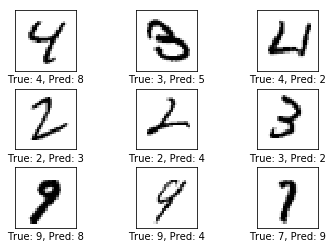

Confusion Matrix:
[[ 903    0   15   11    1   19   17    4    8    2]
 [   1 1069    9    3    5    3   13    4   26    2]
 [  11    7  885   37   10    4    9   14   50    5]
 [  11    5   38  848    0   55    9   14   17   13]
 [   0    1   10    2  874    6   12    5   23   49]
 [  12   16   11   35    9  744   22    7   27    9]
 [   9    7   10    2   11   18  881    1   18    1]
 [   4    9   23   15   10    3    2  869   15   78]
 [   5    7   24   40   20   21   15   12  811   19]
 [   9    6    2   13   92   15    3   33   25  811]]


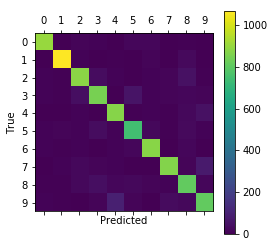

In [58]:
print_test_accuracy(show_confusion_matrix=True, show_example_errors=True)

# 可视化

## 卷积权重

In [59]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## 卷积层输出

In [ ]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## 输出图像

In [ ]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

原始图像

In [ ]:
image1 = data.x_test[0]
plot_image(image1)

# 可视化理解

## 卷积层1

In [ ]:
plot_conv_weights(weights=weights_conv1)

原始图像 => 14*14的像素，原始输入图分辨率的一半

In [ ]:
plot_conv_layer(layer=layer_conv1, image=image1)

## 卷积层2

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

In [ ]:
plot_conv_layer(layer=layer_conv2, image=image1)

In [ ]:
# session.close()